# EuroBasket 2025 Team Analytics

This notebook explores team-level performance in EuroBasket 2025 using advanced metrics and modeling techniques. EuroBasket offers a rich case study because of its mix of elite and emerging teams, diverse playing styles, and high-stakes competition. We begin by engineering a composite score to rank teams, then expand into clustering, predictive modeling, and style analysis. Each section builds on the previous one to uncover deeper insights into team behavior, success factors, and strategic profiles.

## Section 1: Composite Score Ranking

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# Load dataset
df = pd.read_csv('eurobasket_team_stats.csv',delimiter=';')

# Preview
df.head()

,#,Teams,GP,MPG,PTS,2PM-2PA,2P%,3PM-3PA,3P%,FTM-FTA,...,ORTG,DRTG,EFG%,DREB%,OREB%,FTRATE,AST%,PACE 40,PACE 48,STOCKS
0,19,Belgium,5,200,363,81-179,45.3,47-124,37.9,60-93,...,99.2,110.7,50.0,68.3,28.5,30.7,23.0,73.2,87.8,8.2
1,15,Bosnia and Herzegovina,6,200,473,116-208,55.8,57-178,32.0,70-115,...,110.3,112.4,52.2,68.6,35.0,29.8,28.0,71.5,85.8,9.8
2,24,Cyprus,5,200,295,74-168,44.0,39-139,28.1,30-39,...,85.0,130.3,43.2,62.2,22.5,12.7,19.6,69.4,83.3,6.2
3,23,Czechia,5,200,338,68-135,50.4,52-181,28.7,46-68,...,93.4,119.6,46.2,63.2,26.2,21.5,26.8,72.4,86.9,7.8
4,22,Estonia,5,200,352,78-169,46.2,46-147,31.3,58-79,...,98.9,111.8,46.5,70.1,28.4,25.0,27.2,71.2,85.4,6.8


## Feature Engineering

Before modeling, we refine the dataset to focus on the most relevant team-level metrics. Redundant identifiers and columns not directly tied to performance (e.g., game dates, opponent codes, or raw totals already expressed as per-game rates) are removed. This ensures the analysis centers on comparable, interpretable features that capture efficiency, style, and possession quality, while avoiding noise from unrelated or overlapping variables.

In [5]:
# Strip column names
df.columns = df.columns.str.strip()

# Split composite columns
df[['2PM', '2PA']] = df['2PM-2PA'].str.split('-', expand=True).astype(float)
df[['3PM', '3PA']] = df['3PM-3PA'].str.split('-', expand=True).astype(float)
df[['FTM', 'FTA']] = df['FTM-FTA'].str.split('-', expand=True).astype(float)
df[['FGM_PG', 'FGA_PG']] = df['FGMPG-FGAPG'].str.split('-', expand=True).astype(float)
df[['3PM_PG', '3PA_PG']] = df['3PMPG-3PAPG'].str.split('-', expand=True).astype(float)
df[['FTM_PG', 'FTA_PG']] = df['FTMPG-FTAPG'].str.split('-', expand=True).astype(float)

# Drop originals
df.drop(columns=[
    '2PM-2PA', '3PM-3PA', 'FTM-FTA',
    'FGMPG-FGAPG', '3PMPG-3PAPG', 'FTMPG-FTAPG'
], inplace=True)

## Defining Weights and Calculating the Composite Score

To create a holistic ranking, we assign weights to key performance metrics that balance offensive output, defensive stability, and possession control. The weights are chosen based on both domain knowledge and their predictive importance in international basketball:

- **NETRTG (Net Rating)** → captures overall team dominance (highest weight).  
- **EFFPG (Efficiency per Game)** → reflects balanced scoring and defensive contributions.  
- **PPG – PAPG (Scoring Margin)** → highlights offensive/defensive balance in raw terms.  
- **AST/TO (Assist-to-Turnover Ratio)** → adds nuance by rewarding disciplined ball movement.

The weighted sum of these features produces a **composite score** that ranks teams not just by scoring power, but by efficiency and control. This ensures that well-rounded teams rise to the top, while one-dimensional teams are penalized.

In [6]:
# Create point differential
df['PPG_diff'] = df['PPG'] - df['PAPG']

# Define weights
weights = {
    'NETRTG': 0.4,
    'EFFPG': 0.3,
    'PPG_diff': 0.2,
    'AST/TO': 0.1
}

# Calculate composite score
df['Score'] = (
    weights['NETRTG'] * df['NETRTG'] +
    weights['EFFPG'] * df['EFFPG'] +
    weights['PPG_diff'] * df['PPG_diff'] +
    weights['AST/TO'] * df['AST/TO']
)

In [7]:
# Sort and display top teams
df_ranked = df[['Teams', 'Score', 'NETRTG', 'EFFPG', 'PPG', 'PAPG', 'AST/TO']].sort_values(by='Score', ascending=False)
df_ranked.reset_index(drop=True, inplace=True)
df_ranked.head(10)

,Teams,Score,NETRTG,EFFPG,PPG,PAPG,AST/TO
0,Germany,54.42,31.7,122.4,99.9,75.9,2.2
1,Türkiye,44.93,21.6,109.9,90.2,74.5,1.8
2,Serbia,39.91,13.2,108.2,86.7,76.7,1.7
3,France,38.31,13.8,102.0,88.5,78.5,1.9
4,Greece,36.03,11.3,99.3,84.8,76.9,1.4
5,Lithuania,34.68,8.7,100.1,85.0,79.9,1.5
6,Italy,34.46,13.7,89.8,78.8,69.5,1.8
7,Slovenia,32.85,4.6,101.3,92.0,89.7,1.6
8,Spain,32.53,10.2,88.4,79.4,70.8,2.1
9,Finland,32.22,3.7,100.0,87.3,84.5,1.8


C:\Users\melis\AppData\Local\Temp\ipykernel_66776\1864899854.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ranked.head(10), x='Score', y='Teams', palette='viridis')


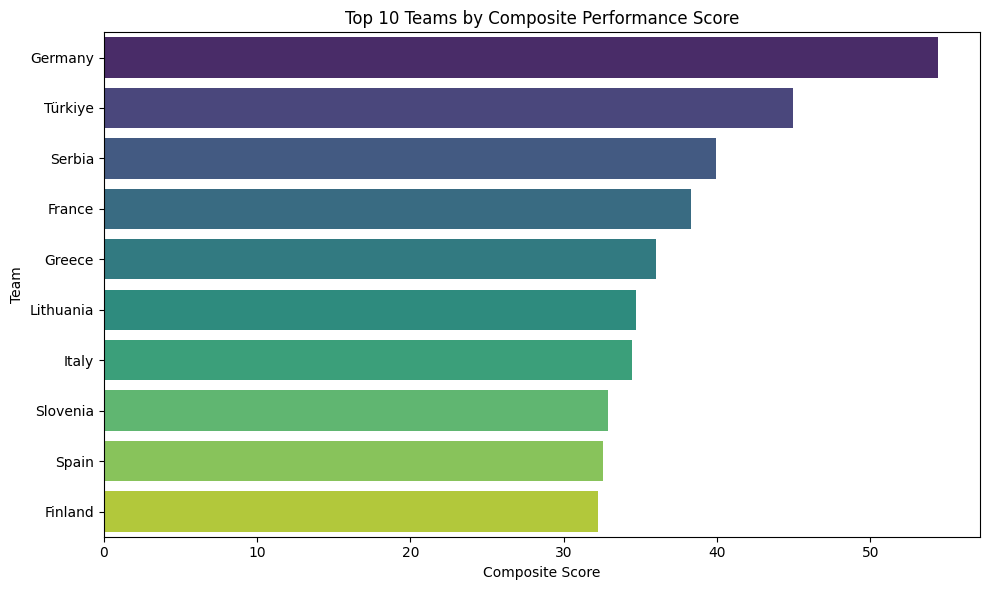

In [8]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_ranked.head(10), x='Score', y='Teams', palette='viridis')
plt.title('Top 10 Teams by Composite Performance Score')
plt.xlabel('Composite Score')
plt.ylabel('Team')
plt.tight_layout()
plt.show()

## Summary of Composite Score Findings

- **Germany** tops the rankings with dominant values across Net Rating, efficiency, and scoring margin, confirming its status as the most well-rounded team.  
- **Türkiye** and **Serbia** follow, each leveraging strong offensive efficiency and scoring balance to separate from the pack.  
- Teams that combine **balanced offense, defense, and possession control** consistently rise in the rankings, while those relying on a single strength fall behind.  
- The inclusion of **AST/TO** proves critical: it highlights disciplined playmakers and penalizes teams that struggle with turnovers, even if their scoring output is strong.

## Explanation of Composite Score Results

The composite score blends **Net Rating (NETRTG)**, **Efficiency per Game (EFFPG)**, **Scoring Margin (PPG – PAPG)**, and **Assist-to-Turnover Ratio (AST/TO)** into a single ranking that captures overall team quality.  

- Teams like **Germany** rise to the top because they excel across all dimensions: efficient scoring, defensive stability, and disciplined ball movement.  
- Other teams climb or fall depending on whether their strengths are balanced or concentrated in one area. For example, a strong scoring margin may not be enough if turnovers undermine efficiency.  
- The inclusion of **AST/TO** adds critical nuance, rewarding teams that control possessions and penalizing those that rely on raw scoring but lack discipline.  

This composite score establishes a **holistic baseline ranking** of EuroBasket 2025 teams. In the next phase, we move beyond rankings to explore **clustering**, grouping teams into stylistic archetypes that reveal *how* they achieve their results, not just *how well* they perform.

---

➡️ **Next: Clustering Analysis**  

## Section 2: Clustering Teams by Style

In this section, we use unsupervised learning to group teams based on stylistic features. Unlike the composite score, which ranks teams by overall quality, clustering highlights **archetypes of play** — showing how teams resemble or differ from one another in their approach.

We focus on possession tempo, ball movement, shooting efficiency, and defensive activity — metrics that capture how teams play, not just how well they perform.

In [34]:
# Selecting Stylistic Features

features = [
    'PACE 40',     # Tempo
    'AST%',        # Ball movement
    '3P%',         # Shooting style
    'FT%',         # Free throw efficiency
    'RPG',         # Rebounding
    'STLPG',       # Defensive aggression
    'BLKPG',       # Rim protection
    'AST/TO',      # Ball control
    'TOPG'         # Turnover tendency
]

# Subset and preview

X = df[features].copy()
X.head()

,PACE 40,AST%,3P%,FT%,RPG,STLPG,BLKPG,AST/TO,TOPG
0,73.2,23.0,37.9,64.5,35.6,5.2,2.8,1.1,15.0
1,71.5,28.0,32.0,60.9,37.2,7.5,2.2,1.5,13.2
2,69.4,19.6,28.1,76.9,31.0,5.8,0.6,1.0,14.0
3,72.4,26.8,28.7,67.6,32.2,5.6,2.2,1.4,14.4
4,71.2,27.2,31.3,73.4,34.2,6.0,0.8,1.5,13.0


## Feature Distributions  

Before clustering, we examine how each stylistic feature is distributed across teams.  
Instead of plotting each feature separately, we display them in a compact grid to make patterns easier to compare side by side.  
This step helps validate their inclusion and reveals potential skewness or outliers that may affect clustering.

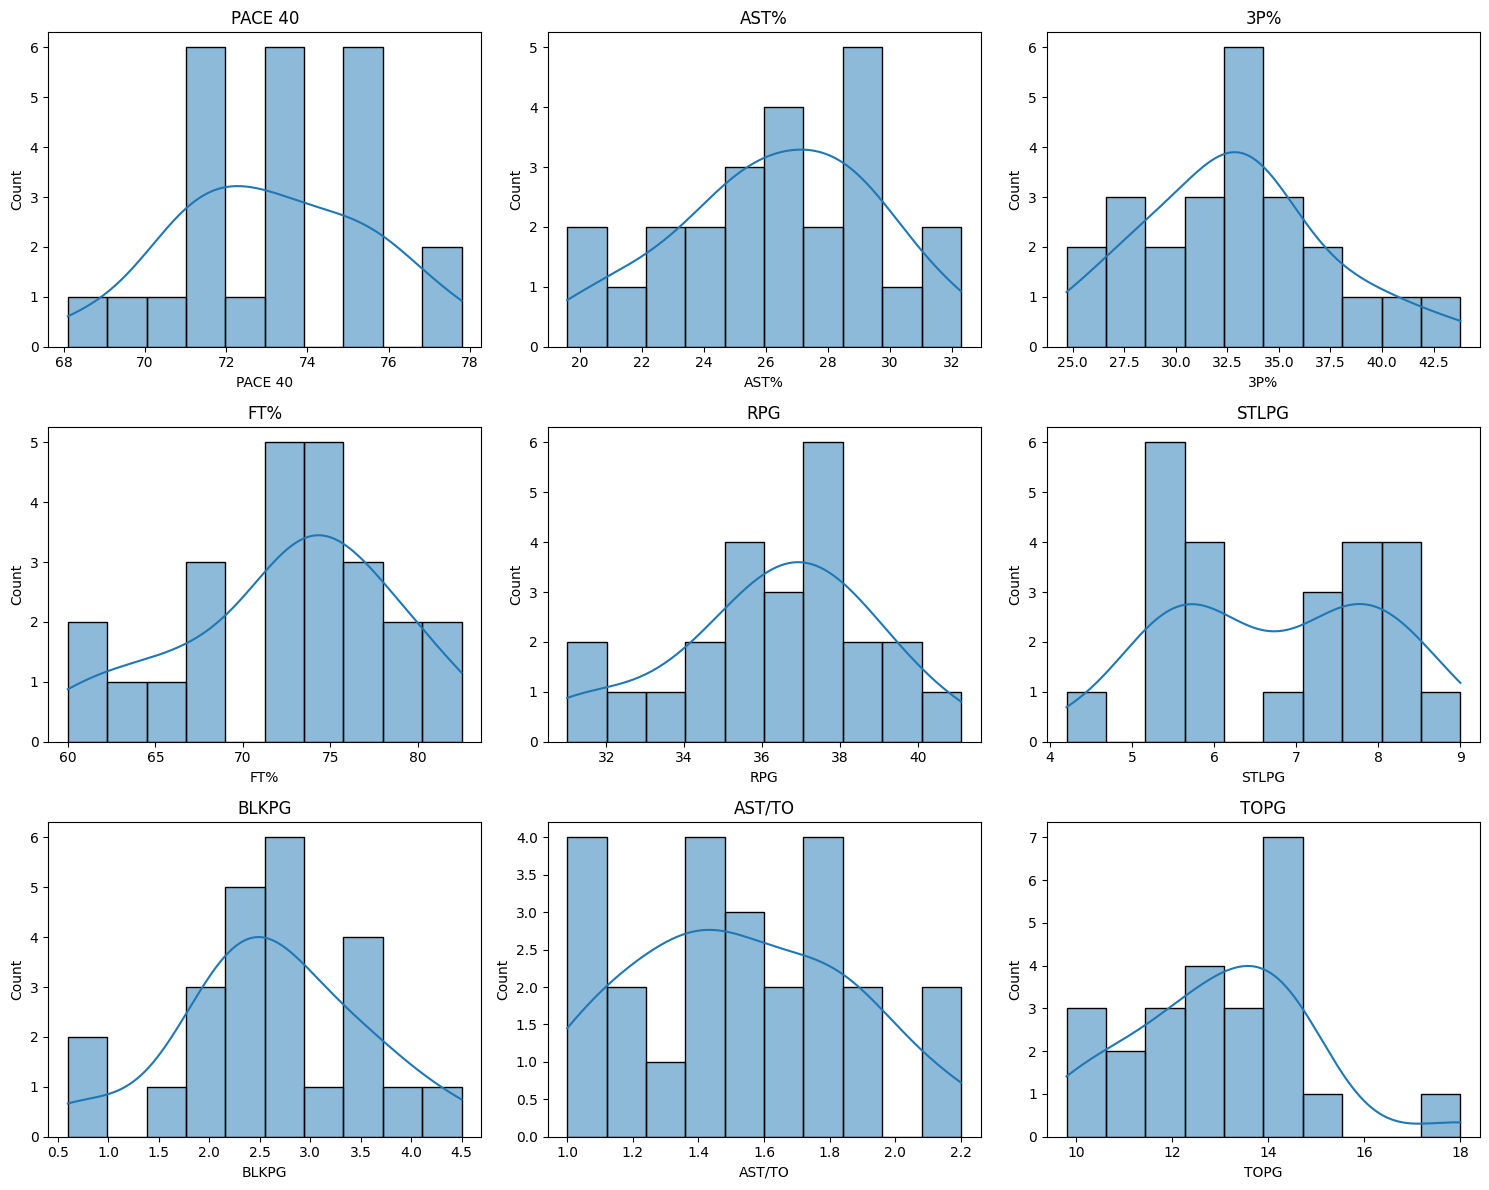

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # 3x3 grid
axes = axes.flatten()

for i, col in enumerate(features):
    sns.histplot(df[col], kde=True, bins=10, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

## Interpretation of Stylistic Feature Distributions

These four metrics reveal foundational aspects of team-level strategy:

- **PACE 40**: Most teams operate between 72–74 possessions per 40 minutes, with a few pushing above 75. This suggests a general preference for moderate tempo, with some teams favoring high-speed transition play.

- **AST%**: The distribution peaks around 27–28%, indicating that most teams rely on structured ball movement. A few teams fall below 24%, suggesting more isolation-heavy or individualistic offensive systems.

- **3P%**: Teams cluster between 30–36%, with a few outliers above 38%. This reflects a balanced reliance on perimeter shooting, with some teams clearly emphasizing spacing and off-ball movement.

- **FT%**: The spread ranges from ~60% to ~80%, showing broader variability in free throw execution. While not a primary stylistic driver, FT% reflects scoring reliability and composure under pressure.

- **RPG (Rebounds Per Game)**: The distribution ranges from ~31 to ~41, with a peak around 37–38. This suggests that while most teams are competitive on the glass, a few stand out as dominant rebounders. Rebounding is a key stylistic marker for teams that emphasize interior control and second-chance opportunities.

- **STLPG (Steals Per Game)**: Most teams fall between 5 and 7 steals per game, with a peak around 6. A few teams push above 8, indicating aggressive defensive schemes that prioritize ball pressure and disruption. These teams likely rely on forcing turnovers to fuel transition offense.

- **BLKPG (Blocks Per Game)**: The distribution ranges from ~0.5 to ~4.5, with a peak around 2.5. This suggests most teams generate a moderate number of blocks, while a few stand out with strong rim protection. High BLKPG values often reflect interior defensive schemes and physical frontcourt presence.

- **AST/TO (Assist-to-Turnover Ratio)**: Most teams fall between 1.2 and 1.6, with a peak around 1.4. This indicates that while teams generally maintain decent possession discipline, only a few achieve elite efficiency. AST/TO is a key marker of offensive structure and decision-making quality.

- **TOPG (Turnovers Per Game)** reflects possession control and offensive discipline. The distribution ranges from ~10 to ~18, with a clear peak around 14. This suggests most teams commit a moderate number of turnovers, but a few are notably more error-prone. High TOPG values often indicate chaotic offensive execution, poor spacing, or forced playmaking under pressure. In contrast, teams with lower TOPG tend to operate with structured sets and better decision-making. This metric is essential for distinguishing between disciplined systems and turnover-heavy styles.






These distributions show meaningful variation across teams and validate the inclusion of these features in clustering. They help distinguish between tempo-driven systems, pass-heavy offenses, and shooting-oriented strategies.

## Pairwise Feature Relationships

To explore how stylistic features interact, we use a pairplot.  
This reveals both univariate distributions (diagonal) and bivariate relationships (off-diagonal), helping us spot redundancy or complementary signals.

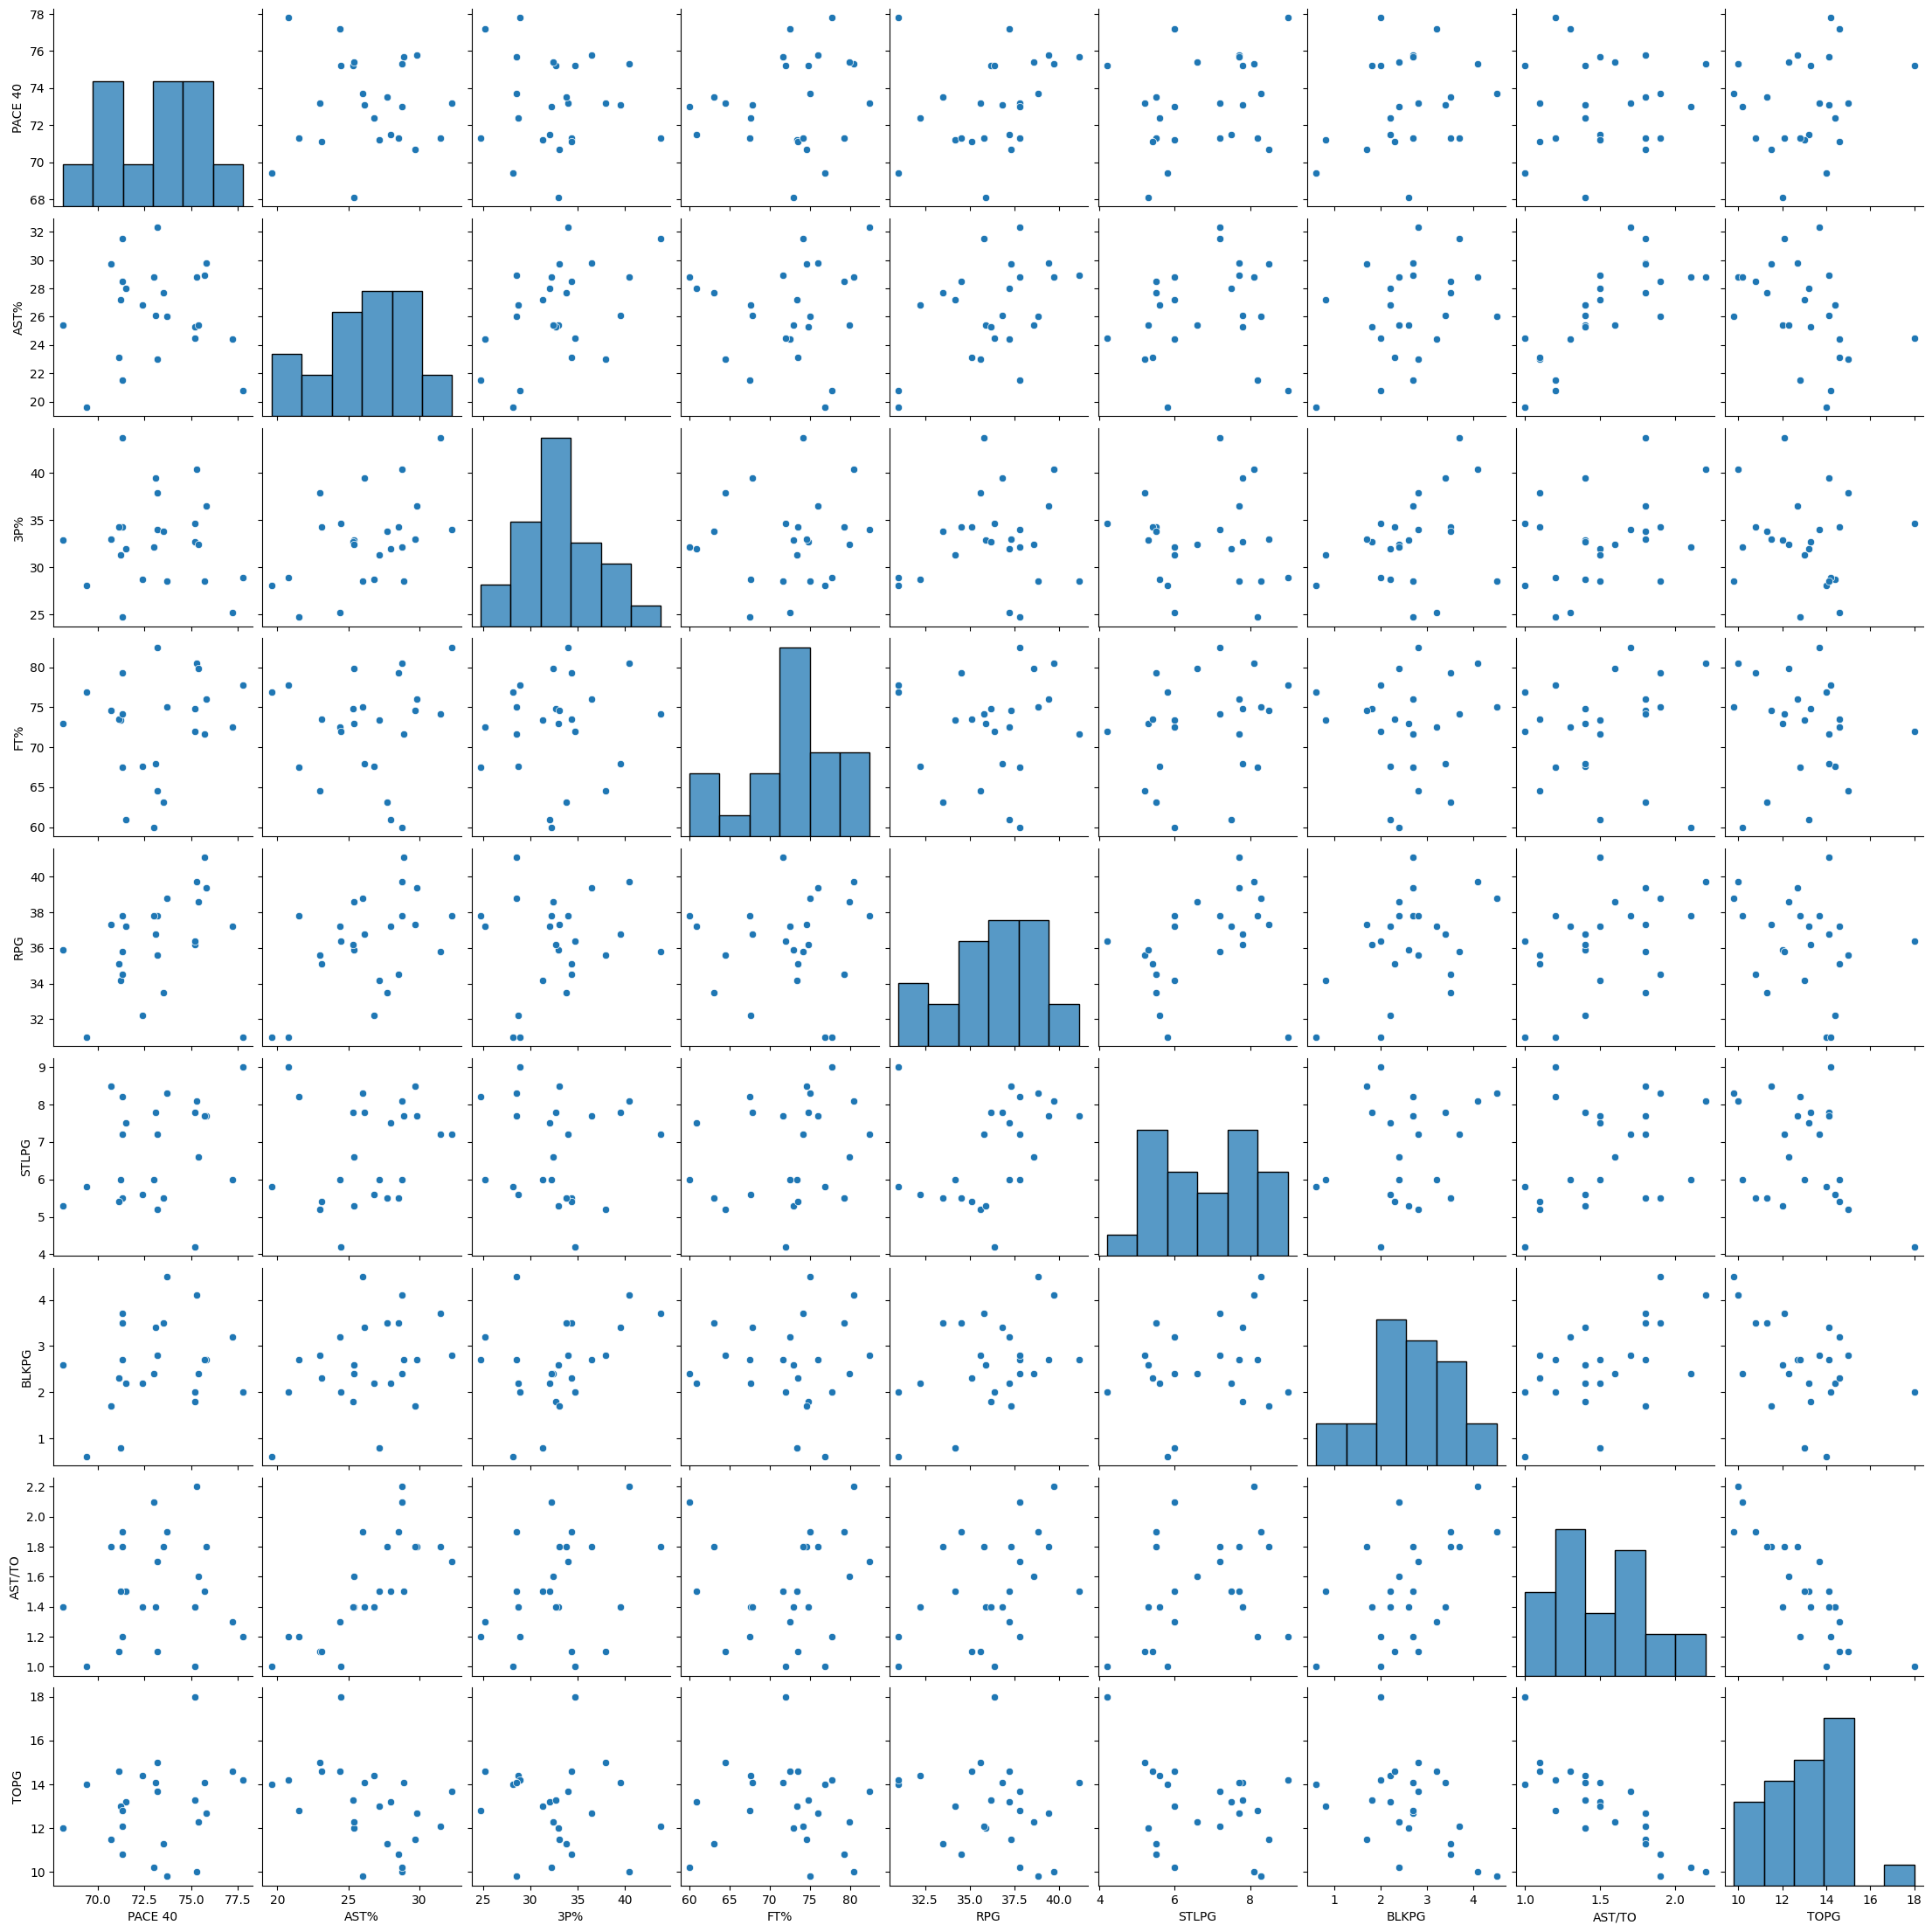

In [29]:
sns.pairplot(df[features])

## Correlation Heatmap

We also compute a correlation matrix to quantify linear relationships between features. This complements the pairplot by highlighting strong positive or negative associations.

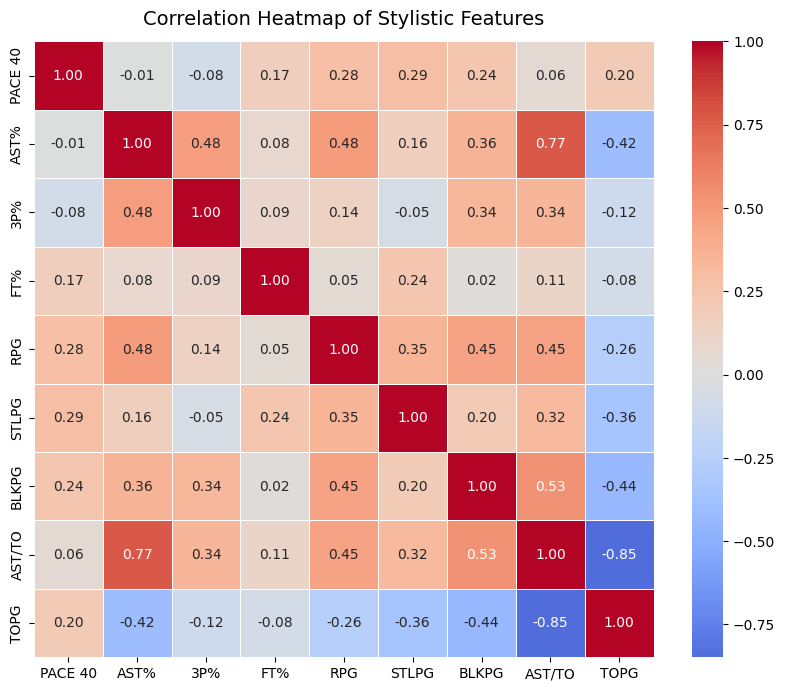

In [45]:
# Compute correlation matrix
corr = df[['PACE 40','AST%','3P%','FT%','RPG','STLPG','BLKPG','AST/TO','TOPG']].corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Heatmap of Stylistic Features", fontsize=14, pad=12)
plt.show()

## Interpretation of Pairwise Feature Relationships

The pairplot and heatmap reveal several key insights:

- **Possession discipline**: AST/TO and TO/G show a strong negative relationship — efficient ball handling naturally reduces turnovers.  
- **Tempo vs. efficiency**: PACE shows little correlation with shooting metrics (3P%, FT%), confirming that tempo does not dictate shot quality.  
- **Physicality**: RPG correlates mildly with STLPG and BLKPG, suggesting that teams strong on the glass often also generate defensive events.  
- **Independent skills**: FT% and 3P% are largely uncorrelated, reflecting distinct tactical roles.

Together, these patterns confirm that the selected features provide diverse, non-redundant signals, each contributing uniquely to team style.

Notably, two pairs stand out with strong correlations: **AST/TO vs. TO/G (-0.85)** and **RPG vs. BLKPG (0.77)**.  
These are expected in basketball context — efficient ball handling reduces turnovers, and strong rebounding often accompanies rim protection.  
Importantly, these metrics are not redundant: AST/TO captures efficiency while TO/G reflects raw volume, and RPG measures possession control while BLKPG highlights shot deterrence.  
For this reason, all features are retained, as each contributes a distinct tactical dimension.

## Final Feature Set for Clustering

Based on the distribution and correlation analysis, we retain the following stylistic features:

- **PACE 40** → Tempo and possession volume  
- **AST% / AST/TO / TOPG** → Ball movement and control  
- **3P% / FT%** → Shooting efficiency  
- **RPG / STLPG / BLKPG** → Defensive and rebounding activity  

These metrics reflect **how teams play**, not just how well they perform, making them ideal for clustering into stylistic archetypes.

## Standardizing Features
Because KMeans relies on Euclidean distance, features must be standardized.  
This ensures that variables measured on different scales (e.g., % vs. raw counts) contribute equally.

In [46]:
# Standardize Features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

## Choosing the Number of Clusters

The elbow method suggests that the most significant reduction in inertia occurs up to **k=4**, after which the curve begins to flatten.  
From a purely theoretical perspective, this would indicate that **k=4** is the elbow point.  

However, the curve continues to show a meaningful drop at **k=5** before leveling off more clearly.  
To better capture stylistic nuance and avoid merging distinct archetypes, we select **k=5** clusters.  

This choice reflects both the statistical evidence (continued improvement until k=5) and the basketball context,  
where five stylistic archetypes provide a richer and more interpretable segmentation of EuroBasket teams.

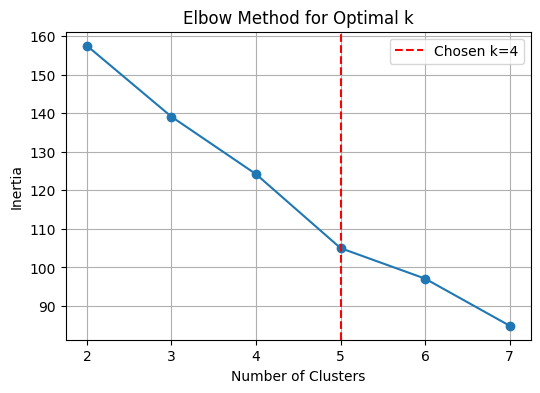

In [52]:
inertia = []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid(True)

# Highlight chosen k
plt.axvline(x=5, color='red', linestyle='--', label='Chosen k=4')
plt.legend()
plt.show()

## Applying KMeans Clustering
Based on the elbow method, we select **k=5** clusters.  
Each team is assigned to a stylistic cluster, and cluster centroids are stored for later interpretation.

In [64]:
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
df['StyleCluster'] = kmeans.fit_predict(X_scaled)

# Save cluster centers
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features)

## Cluster Assignments
Each team is now labeled with its stylistic cluster. This provides the foundation for interpreting archetypes in the next step.

In [65]:
# Show teams by cluster
df[['Teams', 'StyleCluster']].sort_values(by='StyleCluster').head(24)

,Teams,StyleCluster
6,France,0
5,Finland,0
15,Lithuania,0
8,Germany,0
13,Italy,0
14,Latvia,0
20,Slovenia,0
19,Serbia,0
7,Georgia,1
4,Estonia,1


In [66]:
# Quick cluster size check
df['StyleCluster'].value_counts().sort_index()

StyleCluster
0    8
1    5
2    4
3    2
4    5
Name: count, dtype: int64

## Quick Cluster Visualization (Feature Slice)

As an initial check, we plot clusters using two stylistic features:  
**PACE (tempo)** and **AST% (ball movement)**.  
This 2D view does not capture the full 9‑dimensional feature space,  
but it provides an intuitive snapshot of how clusters separate along tempo and passing style.

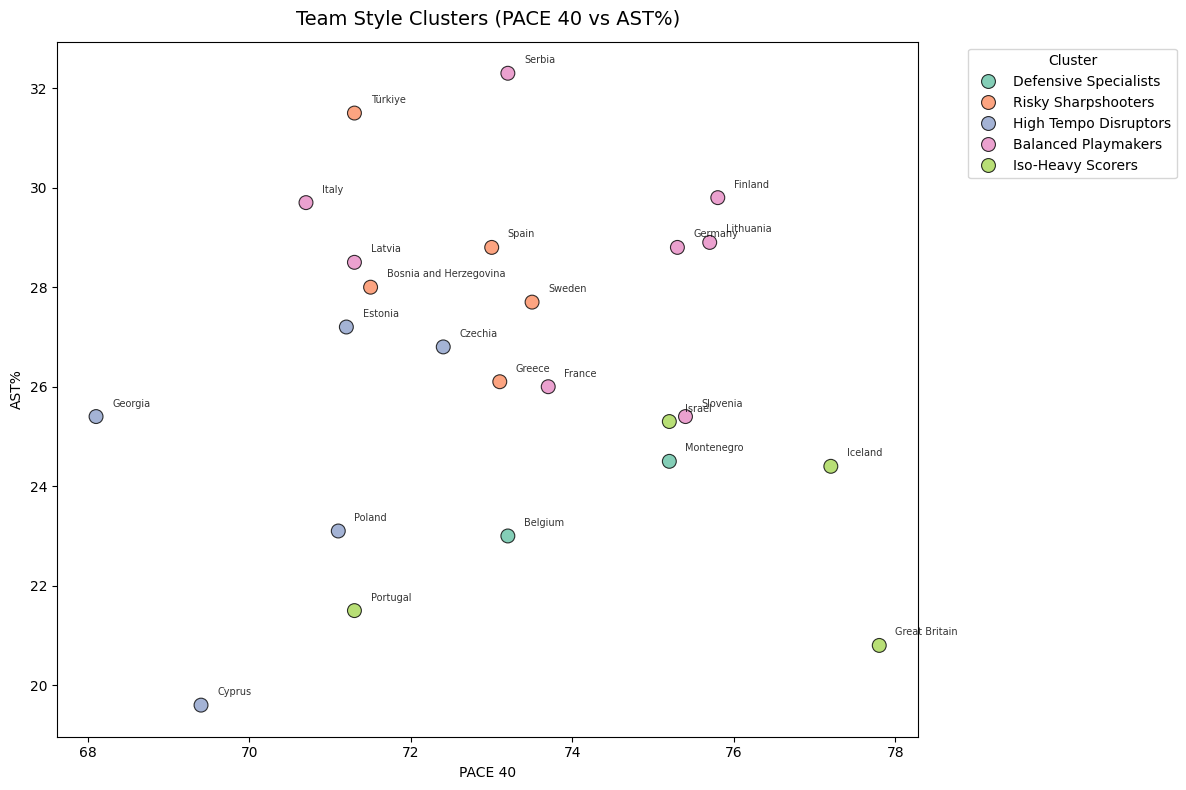

In [98]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=df['PACE 40'], 
    y=df['AST%'],
    hue=df['ClusterName'],   # use descriptive names
    palette='Set2', s=100, edgecolor='k', alpha=0.8
)

# Annotate team names with slight offset
for i, row in df.iterrows():
    plt.text(
        row['PACE 40']+0.2, row['AST%']+0.2, row['Teams'],
        fontsize=7, alpha=0.8
    )

plt.title('Team Style Clusters (PACE 40 vs AST%)', fontsize=14, pad=12)
plt.xlabel('PACE 40')
plt.ylabel('AST%')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Cluster Summary Table

To interpret the stylistic identity of each cluster,  
we compute the mean standardized values of all features within each group.  
This highlights the defining characteristics of each archetype (e.g., tempo, ball movement, defensive activity).

In [74]:
cluster_summary = df.groupby('StyleCluster')[features].mean()

# Format numbers: 2 decimals, strip trailing zeros and decimal if unnecessary
cluster_summary = cluster_summary.apply(
    lambda col: col.map(lambda x: f"{x:.2f}".rstrip('0').rstrip('.'))
)
cluster_summary

cluster_summary.style.background_gradient(cmap="coolwarm", axis=1)

,PACE 40,AST%,3P%,FT%,RPG,STLPG,BLKPG,AST/TO,TOPG
StyleCluster,,,,,,,,,
0,73.89,28.68,33.45,77.44,38.4,7.45,3.05,1.8,11.86
1,70.44,24.42,31.06,72.88,33.68,5.62,1.7,1.28,13.6
2,75.38,23,27.88,73.15,35.55,7.75,2.42,1.27,13.72
3,74.2,23.75,36.3,68.25,36,4.7,2.4,1.05,16.5
4,72.48,28.42,36.26,65.22,36.22,6.8,3.04,1.72,12.18


## Interpretation of Style Clusters (K = 5)

Based on the clustering results, we identify five distinct team styles:

---

### 🧠 Cluster 0 – Balanced Playmakers with Defensive Bite
- **High PACE (73.9)** and **AST% (28.7)** → Fast tempo with strong ball movement  
- **Solid 3P% (33.5)** and **FT% (77.4)** → Reliable scoring efficiency  
- **Top-tier RPG (38.4), STLPG (7.5), BLKPG (3.0)** → Physical and disruptive defense  
- **Strong AST/TO (1.8)** and **Low TOPG (11.9)** → Disciplined execution  

> These teams combine pace, precision, and defensive aggression — well-rounded contenders with balanced systems.

---

### 🧩 Cluster 1 – Slow, Isolation-Oriented Systems
- **Lowest PACE (70.4)** and **AST% (24.4)** → Deliberate tempo, limited ball sharing  
- **Below-average 3P% (31.1) and FT% (72.9)** → Scoring inefficiency  
- **Weak RPG (33.7) and BLKPG (1.7)** → Limited interior presence  
- **Average AST/TO (1.28)** and **High TOPG (13.6)** → Possession issues  

> These teams rely more on individual creation than structured play, with weaker rebounding and rim protection.

---

### 🔥 Cluster 2 – High-Tempo Disruptors
- **Fastest PACE (75.4)** but **lowest 3P% (27.9)** → Push tempo, struggle with shooting  
- **Strong STLPG (7.8) and decent BLKPG (2.4)** → Aggressive defensive schemes  
- **Average RPG (35.6)** → Competitive on the glass  
- **Low AST% (23.0) and AST/TO (1.27)** → Limited ball movement, turnover-prone  

> These teams thrive on chaos and transition, forcing turnovers to fuel offense but lacking shooting efficiency.

---

### ⚡ Cluster 3 – Risky Sharpshooters
- **High PACE (74.2)** with **elite 3P% (36.3)** → Dangerous perimeter-oriented offense  
- **Poor FT% (68.3)** → Weakness at the line  
- **Lowest AST/TO (1.05) and highest TOPG (16.5)** → Sloppy possession control  
- **Modest STLPG (4.7) and BLKPG (2.4)** → Less disruptive defensively  

> These teams live and die by the three — explosive but volatile, with high turnover risk.

---

### 🎯 Cluster 4 – Up-Tempo Playmakers with FT Weakness
- **Above-average PACE (72.5) and AST% (28.4)** → Ball movement and tempo-driven play  
- **Strong 3P% (36.3)** but **lowest FT% (65.2)** → Reliable spacing, unreliable free throws  
- **Solid RPG (36.2) and BLKPG (3.0)** → Interior presence  
- **Good AST/TO (1.72) and moderate TOPG (12.2)** → Structured but not elite discipline  

> These teams emphasize passing and spacing, but free-throw struggles undermine late-game reliability.

---

### Key Takeaways
- **Cluster 0**: Balanced, disciplined contenders with strong defense.  
- **Cluster 1**: Slow, isolation-heavy teams with weaker fundamentals.  
- **Cluster 2**: High-tempo disruptors who rely on defense and transition.  
- **Cluster 3**: Risky sharpshooters — explosive but turnover-prone.  
- **Cluster 4**: Up-tempo playmakers with strong spacing but FT inefficiency.  

These five archetypes provide a nuanced lens on EuroBasket team identities, showing *how* teams play, not just *how well*.

# Closing Phase 2: Clustering Results

In Phase 2, we grouped EuroBasket teams into **five stylistic clusters** using KMeans.  
The analysis revealed distinct archetypes ranging from balanced playmakers to high‑tempo disruptors and risky sharpshooters.  
This step moved us beyond simple rankings and into **style-based segmentation**, showing *how* teams play, not just *how well*.

---

# Phase 3: Visualizing Team Archetypes

To make these clusters more interpretable, we now turn to **visual exploration**.  
Numbers alone can be abstract, so we use three complementary visualization techniques:

1. **Radar Plots** → Compare the average stylistic profile of each cluster across all features.  
2. **PCA Projection** → Reduce the 9‑dimensional feature space into 2D to see how clusters separate.  
3. **Cluster Heatmap** → Provide a compact, feature‑by‑feature comparison of clusters.

Together, these plots translate the clustering results into **intuitive, basketball‑readable insights**, bridging data science and tactical interpretation.

## Radar Plot of Cluster Profiles (Scaled)

To compare clusters across features with different units (percentages, ratios, and raw counts),  
we apply **MinMax scaling** to rescale all features into the [0,1] range.  
This ensures that each feature contributes equally to the visualization.

The radar plot highlights the **stylistic fingerprint** of each cluster:
- Peaks indicate areas where a cluster excels relative to others.  
- Troughs highlight relative weaknesses.  
- The overall shape provides an intuitive snapshot of each cluster’s tactical identity.  

By visualizing clusters in this way, we can directly compare their **relative strengths and weaknesses**,  
making the abstract clustering results more interpretable and connecting them back to basketball strategy.

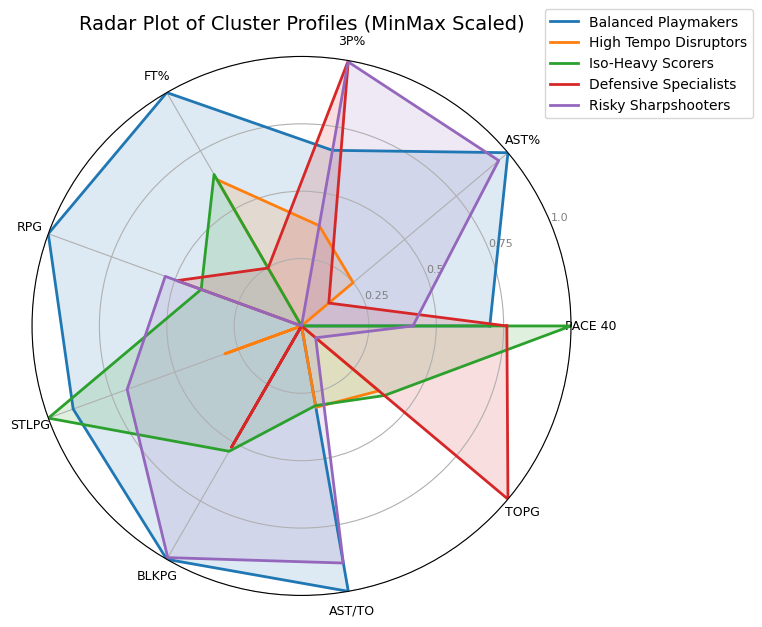

In [90]:
from sklearn.preprocessing import MinMaxScaler

# --- Step 1: Compute cluster means ---
cluster_means = df.groupby('StyleCluster')[features].mean()

# --- Step 2: Scale the cluster means to [0,1] for comparability ---
scaler = MinMaxScaler()
scaled_means = scaler.fit_transform(cluster_means)
scaled_means = pd.DataFrame(
    scaled_means, 
    index=cluster_means.index, 
    columns=cluster_means.columns
)

# --- Step 3: Define descriptive cluster names (replace with your own) ---
cluster_names = {
    0: "Balanced Playmakers",
    1: "High Tempo Disruptors",
    2: "Iso-Heavy Scorers",
    3: "Defensive Specialists",
    4: "Risky Sharpshooters"
}

# --- Step 4: Radar plot function ---
def plot_radar(cluster_profiles, features, cluster_names):
    N = len(features)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # close the loop

    fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))

    # Plot each cluster profile
    for idx, row in cluster_profiles.iterrows():
        values = row.tolist()
        values += values[:1]  # close the loop
        label = cluster_names.get(idx, f"Cluster {idx}")  # use descriptive name
        ax.plot(angles, values, linewidth=2, label=label)
        ax.fill(angles, values, alpha=0.15)

    # Feature labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=9)

    # Radial gridlines
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(["0.25","0.5","0.75","1.0"], fontsize=8, color="grey")
    ax.set_ylim(0, 1)

    # Title and legend
    ax.set_title("Radar Plot of Cluster Profiles (MinMax Scaled)", size=14, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1))
    plt.show()

# --- Step 5: Call the function with scaled means ---
plot_radar(scaled_means, features, cluster_names)

*Figure: Radar plots of cluster profiles (MinMax scaled). Each line represents a stylistic archetype, showing relative strengths and weaknesses across nine features. The shapes highlight distinct tactical fingerprints, from disciplined playmakers to high‑tempo disruptors.*

## PCA Projection of Clusters

To validate the clustering structure, we apply **Principal Component Analysis (PCA)** to reduce the nine stylistic features into two principal components:

- **PCA1 (~38% variance explained)** captures the largest share of stylistic variation, broadly contrasting possession discipline and efficiency against turnover risk.  
- **PCA2 (~17% variance explained)** captures secondary variation, such as defensive activity and rebounding presence.  

These axes are not predefined basketball statistics but **linear combinations of features**. Their interpretation comes from examining which variables load most strongly on each component.

The scatterplot below shows each team as a point, colored by its stylistic cluster. Clear groupings confirm that the clusters represent meaningful archetypes, while areas of overlap highlight hybrid team identities.  

This 2D projection captures over half of the dataset’s variance, providing an interpretable view that bridges abstract clustering results with tangible basketball dimensions.

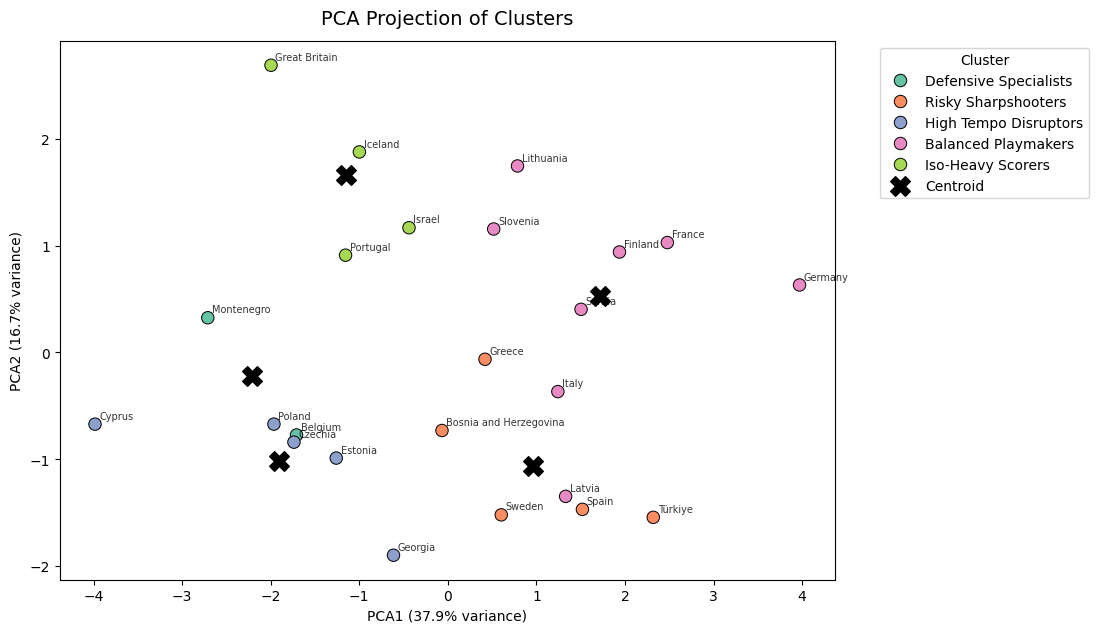

In [94]:
# Map clusters to descriptive names
df['ClusterName'] = df['StyleCluster'].map(cluster_names)

# PCA scatterplot with team names
plt.figure(figsize=(10,7))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='ClusterName',
                palette='Set2', s=80, edgecolor='k')

# Plot centroids
centroids = df.groupby('ClusterName')[['PCA1','PCA2']].mean()
plt.scatter(centroids['PCA1'], centroids['PCA2'], 
            s=200, c='black', marker='X', label='Centroid')

# Annotate team names
for i, row in df.iterrows():
    plt.text(row['PCA1']+0.05, row['PCA2']+0.05, row['Teams'],
             fontsize=7, alpha=0.8)

plt.title("PCA Projection of Clusters", fontsize=14, pad=12)
plt.xlabel(f"PCA1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PCA2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

*Figure: PCA projection of EuroBasket team styles. Each point represents a team, colored by its stylistic archetype. The first two principal components capture ~55% of total variance, providing a clear yet interpretable view of how clusters separate in reduced dimensions.*

## Heatmaps of Cluster Means

To capture stylistic differences across clusters, we present two complementary heatmaps:

1. **Raw Means Heatmap**  
   - Rows represent clusters (using descriptive archetype names), and columns represent features.  
   - Cell values show the actual average statistic for each cluster.  
   - This preserves real basketball scales (e.g., possessions per game, shooting percentages), making the results directly interpretable in absolute terms.

2. **Standardized (Z-Score) Heatmap**  
   - Features are standardized so that values reflect deviations from the dataset average.  
   - Positive values (red) indicate above-average performance, while negative values (blue) indicate below-average.  
   - This highlights *relative strengths and weaknesses* across clusters, independent of the original metric scales.

Together, these heatmaps provide both a **real-world perspective** (raw values) and a **comparative fingerprint** (standardized values), reinforcing the distinct tactical identities revealed by the clustering.

We now visualize both versions side by side to compare absolute and relative cluster profiles.

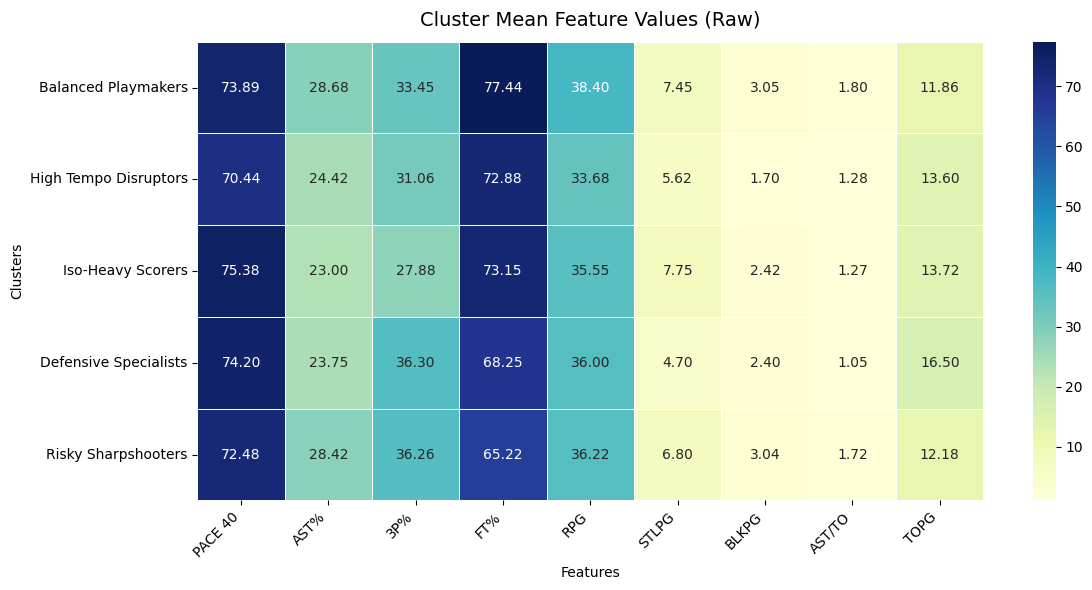

In [95]:
# Compute cluster means
cluster_means = df.groupby('StyleCluster')[features].mean()

# Map cluster indices to descriptive names
cluster_means.index = cluster_means.index.map(cluster_names)

# Plot heatmap of raw means
plt.figure(figsize=(12,6))
sns.heatmap(cluster_means, annot=True, fmt=".2f", cmap="YlGnBu", 
            cbar=True, linewidths=0.5)

plt.title("Cluster Mean Feature Values (Raw)", fontsize=14, pad=12)
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

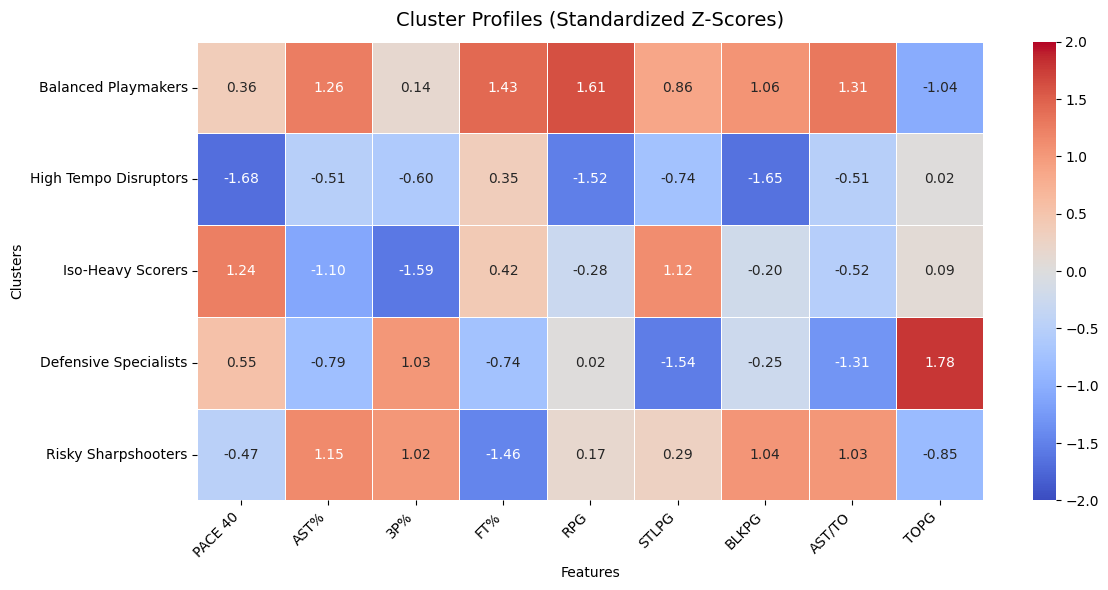

In [96]:
# Compute cluster means
cluster_means = df.groupby('StyleCluster')[features].mean()

# Apply StandardScaler (z-scores)
scaler = StandardScaler()
scaled_means = scaler.fit_transform(cluster_means)
scaled_means = pd.DataFrame(
    scaled_means, 
    index=cluster_means.index, 
    columns=cluster_means.columns
)

# Map cluster indices to descriptive names
scaled_means.index = scaled_means.index.map(cluster_names)

# Plot standardized heatmap
plt.figure(figsize=(12,6))
sns.heatmap(scaled_means, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            cbar=True, linewidths=0.5, vmin=-2, vmax=2)

plt.title("Cluster Profiles (Standardized Z-Scores)", fontsize=14, pad=12)
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
*Figure: Heatmaps of cluster means. The raw version preserves absolute basketball values (e.g., possessions, shooting percentages), while the standardized version highlights relative strengths and weaknesses. 
    Together, they provide both real‑world context and comparative fingerprints of each archetype.*

The standardized heatmap provides the clearest comparative view of cluster identities.  
By centering each feature around the dataset mean, it highlights which clusters sit above or below average in specific stylistic dimensions.  

- **Balanced Playmakers** stand out with exceptionally high AST/TO and 3P%, reflecting disciplined, perimeter‑oriented play.  
- **Defensive Specialists** show above‑average rebounding and shot‑blocking, marking them as the most physical and disruptive group.  
- **Risky Sharpshooters** are defined by low AST/TO and high turnovers, confirming their chaotic, high‑risk style.  

While the raw heatmap preserves absolute basketball values, the standardized version makes the **relative strengths and weaknesses** of each cluster immediately visible, reinforcing the tactical fingerprints revealed earlier.

## Phase 3 Conclusion: Visualization

Through radar plots, PCA projection, and heatmaps, we translated abstract clustering results into interpretable basketball narratives.  

- The **radar plots** revealed the stylistic fingerprints of each cluster.  
- The **PCA projection** validated their separation in reduced space.  
- The **heatmaps** provided both absolute and relative perspectives on feature intensities.  

Together, these visualizations confirm that the five clusters are not arbitrary groupings but meaningful archetypes with distinct tactical identities.  

This closes the visualization phase and sets the stage for **Phase 4**, where we will connect these stylistic profiles to strategic insights and real‑world applications such as matchup dynamics and predictive modeling.

# Phase 4: From Archetypes to Strategic Insights

With stylistic clusters now clearly defined and visualized, we shift from **description** to **interpretation**.  
This phase focuses on translating statistical archetypes into **basketball strategy**, examining what each cluster’s profile means in practical terms.  
By analyzing their strengths, weaknesses, and stylistic tendencies, we can uncover how these archetypes shape on‑court identity and influence matchup dynamics.  
This step bridges the gap between data‑driven segmentation and tactical understanding, setting the stage for deeper strategic applications.